In [1]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

# Add Identification directory to path for baseline_inference import
identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore




Helper imported succesfully


In [2]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [3]:
# Import controllers module from experiments directory
experiments_path = Path.cwd().resolve().parent / 'experiments'
if str(experiments_path) not in sys.path:
    sys.path.append(str(experiments_path))

import controllers

# Load all necessary data and setup
controllers.load()

# Make loaded variables accessible in the notebook
A = controllers.A
B = controllers.B
C = controllers.C
loaded_setup = controllers.loaded_setup
nz = controllers.nz
nu = controllers.nu
ny = controllers.ny
nd = controllers.nd
T_real = controllers.T_real
A_block = controllers.A_block
A_transformed = controllers.A_transformed
A_backtransformed = controllers.A_backtransformed
problem = controllers.problem
scaler = controllers.scaler
scalerU = controllers.scalerU
y_start = controllers.y_start
y_start_ns = controllers.y_start_ns
reference = controllers.reference
y_setpoint = controllers.y_setpoint
u_previous = controllers.u_previous
u_previous_ns = controllers.u_previous_ns
P0 = controllers.P0
Q = controllers.Q
R = controllers.R
A_ = controllers.A_
B_ = controllers.B_
C_ = controllers.C_
KF = controllers.KF
target_estimation = controllers.target_estimation
mpc = controllers.mpc

print("Controllers module loaded successfully!")
print(f"Loaded matrices: A {A.shape}, B {B.shape}, C {C.shape}")
print(f"State dimension: {nz}, Input dimension: {nu}, Output dimension: {ny}")
print(f"Disturbance dimension: {nd}")

Models imported succesfully
Close to block diagonal? True
Backtransformation equals original A? True
Controllers module loaded successfully!
Loaded matrices: A (15, 15), B (15, 3), C (3, 15)
State dimension: 15, Input dimension: 3, Output dimension: 3
Disturbance dimension: 3


In [4]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# # Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# # ------------------------------ IO utilities ----------------------------------






# def load_scalers(data_dir: Path):
#     scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
#     scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
#     return scaler, scalerU



# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    cons = 3
    layers = [6*cons,12*cons,18*cons]
    layers_dec  = [18*cons,12*cons,6*cons]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem


def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T


def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)





In [5]:
data_dir = REPO_ROOT / '../data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = True
A = np.load(f"../data/A_C_{matrix_C}.npy")
B = np.load(f"../data/B_C_{matrix_C}.npy")
C = np.load(f"../data/C_C_{matrix_C}.npy")

nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# # Resample A and B from Ts=1 to Ts=10 seconds
# Ts_old = 1.0    # original timestep in seconds
# Ts_new = 10.0   # desired timestep in seconds

# # Assume system is already in discrete time with Ts=1.0
# # To resample A, B to Ts=10.0, use the method for "resampling" discrete systems:
# #   A_10 = A_1^10
# #   B_10 = sum_{i=0}^{9} A_1^i @ B_1

# import scipy.linalg as la

# # Convert to continuous through matrix log
# Ac = la.logm(A) / Ts_old
# Bc = np.linalg.solve(Ac, (A - np.eye(A.shape[0]))) @ B

# # Re-discretize at Ts_new
# A = A_10 = la.expm(Ac * Ts_new)
# B = B_10 = np.linalg.solve(Ac, (A_10 - np.eye(A.shape[0]))) @ Bc
# print(np.max(A.imag))
# A = np.real(A)  # or use np.real(A_10) if you're sure
# B = np.real(B)

# # A_10 = np.linalg.matrix_power(A, int(Ts_new / Ts_old))

# # sum_term = np.zeros_like(B)
# # A_power = np.eye(A.shape[0])
# # for i in range(int(Ts_new / Ts_old)):
# #     sum_term += A_power @ B
# #     A_power = A @ A_power
# # B_10 = sum_term

# # A = A_10
# # B = B_10

# np.save(f"../data/A_C_{matrix_C}_Ts.npy", A)
# np.save(f"../data/B_C_{matrix_C}_Ts.npy", B)



# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [6]:
data_dir

PosixPath('/Users/patrik/Documents/Research/2025-2026/offset-free-koopman-mpc/pausterization_unit/../data')

In [7]:
(data_dir / f'model_C_{matrix_C}.pth').as_posix()

'/Users/patrik/Documents/Research/2025-2026/offset-free-koopman-mpc/pausterization_unit/../data/model_C_True.pth'

In [8]:
B.shape

(15, 3)

In [9]:


# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load(f'../data/model_C_{matrix_C}.pth'), strict=False)

# Load scalers
scaler, scalerU = baseline_inference.scaler, baseline_inference.scalerU
# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [10]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

# Initial state estimate includes disturbance
z_est_ = np.hstack(((inv(T_real) @ get_x_from_y(problem, y_start)).T, np.zeros((1, nd))))

P0 = np.eye(nz + nd)*loaded_setup['P0']
Q = np.eye(nz + nd)*loaded_setup['Q']
Q = np.block([
        [np.eye(nz) * loaded_setup['Q'],  np.zeros((nz, nd))],   # Trust state model
        [np.zeros((nd, nz)), np.eye(nd) * 0.05]      # Disturbance adapts fast
    ])
R = np.eye(ny)*loaded_setup['R']

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
C_ = np.hstack([
    C, np.eye(nd),
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)



In [11]:
P0.shape

(18, 18)

In [12]:
C

array([[ 0.28706366,  0.21089719, -0.5452582 ,  0.27454382,  0.12636288,
         0.10752011, -0.0890633 ,  0.0450753 , -0.02438587,  0.16639072,
         0.01036739, -0.06868934, -0.14280535,  0.03048017,  0.16569021],
       [ 0.44358757, -0.17708637,  0.07623932, -0.09267771,  0.00806589,
        -0.10221583,  0.13452485,  0.01702541, -0.07152184,  0.14591712,
         0.17777753,  0.00105965,  0.23779987, -0.02052395, -0.07197988],
       [ 0.26298168,  0.14731038, -0.3267395 , -0.10297121, -0.1771365 ,
         0.1110369 , -0.18263873, -0.01618825,  0.33044928, -0.12654804,
         0.09818555, -0.05319883, -0.02616829, -0.03305138, -0.11523008]],
      dtype=float32)

In [13]:
z_est_[:, :]

array([[ 0.38065806,  2.77994704, -0.05787914, -0.2438338 , -0.20592239,
        -0.08186362,  0.09842159, -0.10723274, -0.00379966,  0.12735547,
         0.03403376, -0.18171671, -0.1163477 ,  0.00673567,  0.11755444,
         0.        ,  0.        ,  0.        ]])

In [14]:
# Target calc
target_estimation = helper.TargetEstimation(A, B, C)
z_s, y_s, u_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint)
z_ref = z_s


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05


In [15]:
z_s

array([ 1.72089614,  0.28019272, -0.07165695, -0.41228953,  0.2601301 ,
        0.21346942,  0.6558722 , -0.36634491,  0.30958971, -0.18482586,
       -0.17655343, -1.17651632, -0.55952917,  2.44497364, -0.34377883])

In [16]:
y_s - y_setpoint

array([-2.10386890e-08, -1.71083236e-09,  2.12344178e-08])

In [17]:
# Before calling build_problem, check Qu as well
print("Qu is PSD?", np.all(np.linalg.eigvalsh(loaded_setup['Qu']) >= -1e-10))

Qu is PSD? True


In [18]:
Qx = C.T@loaded_setup['Qy']@C + 2e-8 * np.eye(A.shape[0])



# Check if Qx is positive semi-definite
eigvals = np.linalg.eigvals(Qx)
# min_eigval = np.min(eigvals)
# if min_eigval < 0:
#     # Add enough regularization to make it PSD
#     Qx = Qx + (abs(min_eigval) + 1e-6) * np.eye(A.shape[0])

is_psd = np.all(eigvals >= 1e-8)
is_psd


np.True_

In [19]:
C @ z_est_[:, :nz].T

array([[ 0.68216617],
       [-0.29868325],
       [ 0.54969996]])

In [20]:
(C @ z_est_[:, :nz].T) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [21]:
(C @ z_est_[:, :nz].T) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [22]:
# MPC problem
mpc = helper.MPC(A, B, C)
mpc.build_problem(Qx)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_previous, z_ref)

# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [23]:
y_start

array([[ 0.67623006, -0.06191781,  0.67019906]])

In [24]:
baseline_inference.get_x(y_start)

In [25]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
u_prev = scalerU.inverse_transform(u_prev.reshape(1, -1))[0]


if u_previous_ns is not None:
    u_sim_ns[:, 0] = u_previous_ns.flatten()
else:
    u_sim_ns[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]

for k in tqdm(range(sim_time), desc="Closed-loop simulation", ncols=80):
    idx_prev = max(k - 1, 0)        
    # Target update
    # zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
    #     z_sim[nz:, k], loaded_setup["reference"][:, k]
    # )

    # # MPC
    # u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    # u_sim[:, k] = u_opt
    # u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    #function check
    ys_sim[:, k], u_opt, us_sim[:, k] = controllers.next_optimal_input(u_prev, y_sim_ns[:,k], k)
    u_sim_ns[:, k] = u_opt
    u_sim[:, k] = scalerU.transform(u_opt.reshape(1, -1))[0]
    # Plant
    # for i in range(int(10-1)):
    #     baseline_inference.y_plus(u_sim[:, k])
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    noise_std = 0.01  # You can adjust this value as desired
    noise = np.random.normal(0, noise_std, size=y_sim[:, k + 1].shape)
    y_sim[:, k + 1] += noise
    y_sim_ns[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]
    # Estimation
    # z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()

    # controllers estimation
    z_sim[:, k + 1] = controllers.KF.x.flatten()
    
    u_prev = u_opt
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)


Closed-loop simulation:   0%|                   | 1/500 [00:00<01:38,  5.07it/s]

[[0.00282356]
 [0.20230805]
 [0.01247233]]
[[0.01398657]
 [0.34860425]
 [0.01728804]]


Closed-loop simulation:   1%|▏                  | 6/500 [00:00<00:32, 15.33it/s]

[[0.02636507]
 [0.38311633]
 [0.03612828]]
[[0.0430364 ]
 [0.39093643]
 [0.05373541]]
[[0.05997055]
 [0.40214063]
 [0.06946611]]
[[0.09323079]
 [0.41695047]
 [0.08149336]]
[[0.12359421]
 [0.43106318]
 [0.08991982]]


Closed-loop simulation:   2%|▎                  | 8/500 [00:00<00:34, 14.35it/s]

[[0.1495881 ]
 [0.45462967]
 [0.10710558]]
[[0.16644207]
 [0.47882822]
 [0.10422616]]
[[0.16981717]
 [0.51478834]
 [0.10317194]]


Closed-loop simulation:   2%|▍                 | 12/500 [00:00<00:37, 12.91it/s]

[[0.16529505]
 [0.5511229 ]
 [0.09810729]]
[[0.15116681]
 [0.58974323]
 [0.0918418 ]]
[[0.13003714]
 [0.62989243]
 [0.08603746]]
[[0.09911605]
 [0.6675314 ]
 [0.08025797]]


Closed-loop simulation:   3%|▌                 | 16/500 [00:01<00:32, 15.09it/s]

[[0.07403825]
 [0.69571318]
 [0.07399854]]
[[0.04043628]
 [0.7170095 ]
 [0.07017658]]
[[0.00379286]
 [0.73340208]
 [0.05762239]]
[[-0.03848197]
 [ 0.73228384]
 [ 0.04238383]]


Closed-loop simulation:   4%|▋                 | 20/500 [00:01<00:30, 15.78it/s]

[[-0.08567032]
 [ 0.717712  ]
 [ 0.02482218]]
[[-0.13230519]
 [ 0.69123055]
 [-0.0009878 ]]
[[-0.18945488]
 [ 0.65733041]
 [-0.02609819]]


Closed-loop simulation:   4%|▊                 | 22/500 [00:01<00:34, 13.76it/s]

[[-0.23335124]
 [ 0.61163882]
 [-0.05188101]]
[[-0.27723368]
 [ 0.56496272]
 [-0.08121721]]
[[-0.31679344]
 [ 0.52016372]
 [-0.11232641]]


Closed-loop simulation:   5%|▊                 | 24/500 [00:01<00:43, 10.87it/s]

[[-0.3551183 ]
 [ 0.47766824]
 [-0.1415834 ]]


Closed-loop simulation:   6%|█                 | 28/500 [00:02<00:44, 10.58it/s]

[[-0.38495618]
 [ 0.43645443]
 [-0.16613324]]
[[-0.41217128]
 [ 0.40022311]
 [-0.18076045]]
[[-0.4279435 ]
 [ 0.37390081]
 [-0.19846052]]
[[-0.43904228]
 [ 0.34241888]
 [-0.20323016]]


Closed-loop simulation:   6%|█                 | 30/500 [00:02<00:39, 12.00it/s]

[[-0.43859787]
 [ 0.31565802]
 [-0.20379835]]
[[-0.42913405]
 [ 0.29765349]
 [-0.1987539 ]]


Closed-loop simulation:   7%|█▏                | 34/500 [00:02<00:37, 12.36it/s]

[[-0.41118188]
 [ 0.28869878]
 [-0.18839941]]
[[-0.38317738]
 [ 0.277897  ]
 [-0.17392803]]
[[-0.35301111]
 [ 0.27226992]
 [-0.15405252]]
[[-0.31305179]
 [ 0.27209441]
 [-0.13638177]]


Closed-loop simulation:   8%|█▎                | 38/500 [00:02<00:32, 14.32it/s]

[[-0.26833898]
 [ 0.27438061]
 [-0.11476483]]
[[-0.2272148 ]
 [ 0.27719349]
 [-0.09609484]]
[[-0.18364593]
 [ 0.29075527]
 [-0.08033571]]
[[-0.14457893]
 [ 0.29993429]
 [-0.0618076 ]]


Closed-loop simulation:   8%|█▍                | 40/500 [00:03<00:35, 12.89it/s]

[[-0.11175316]
 [ 0.3145063 ]
 [-0.04778803]]
[[-0.08536013]
 [ 0.32940558]
 [-0.03474253]]


Closed-loop simulation:   8%|█▌                | 42/500 [00:03<00:44, 10.19it/s]

[[-0.06493554]
 [ 0.34584558]
 [-0.02856837]]
[[-0.05552016]
 [ 0.3687241 ]
 [-0.02101008]]


Closed-loop simulation:   9%|█▌                | 44/500 [00:03<00:49,  9.14it/s]

[[-0.05583406]
 [ 0.39839416]
 [-0.01915178]]
[[-0.06235984]
 [ 0.42776118]
 [-0.02229866]]
[[-0.06852462]
 [ 0.45214808]
 [-0.02165135]]


Closed-loop simulation:  10%|█▋                | 48/500 [00:03<00:37, 12.02it/s]

[[-0.08107042]
 [ 0.47911899]
 [-0.0249855 ]]
[[-0.09440293]
 [ 0.50206664]
 [-0.02615909]]
[[-0.10680648]
 [ 0.5166703 ]
 [-0.03228242]]
[[-0.11913806]
 [ 0.53086316]
 [-0.03093043]]


Closed-loop simulation:  10%|█▊                | 52/500 [00:04<00:32, 13.96it/s]

[[-0.12525611]
 [ 0.54032433]
 [-0.03028004]]
[[-0.12662961]
 [ 0.54334509]
 [-0.03146598]]
[[-0.12307384]
 [ 0.540037  ]
 [-0.03611982]]
[[-0.11843754]
 [ 0.52941479]
 [-0.02791177]]


Closed-loop simulation:  11%|██                | 56/500 [00:04<00:33, 13.18it/s]

[[-0.10820868]
 [ 0.51909827]
 [-0.02439124]]
[[-0.09985592]
 [ 0.51183876]
 [-0.02508008]]
[[-0.08938472]
 [ 0.49817227]
 [-0.01851352]]


Closed-loop simulation:  12%|██▏               | 60/500 [00:04<00:34, 12.61it/s]

[[-0.08059847]
 [ 0.47879067]
 [-0.01764709]]
[[-0.06540764]
 [ 0.46208466]
 [-0.01341415]]
[[-0.05778072]
 [ 0.44445733]
 [-0.01166335]]
[[-0.05371124]
 [ 0.42430938]
 [-0.00501294]]


Closed-loop simulation:  13%|██▎               | 64/500 [00:05<00:30, 14.11it/s]

[[-0.04724268]
 [ 0.41266899]
 [ 0.00142427]]
[[-0.03995863]
 [ 0.40038318]
 [ 0.00514584]]
[[-0.03040454]
 [ 0.39421142]
 [ 0.01033035]]
[[-0.02748174]
 [ 0.38777307]
 [ 0.01548165]]


Closed-loop simulation:  14%|██▍               | 68/500 [00:05<00:27, 15.54it/s]

[[-0.01896498]
 [ 0.37806766]
 [ 0.02710781]]
[[-0.012908  ]
 [ 0.36972718]
 [ 0.03177676]]
[[-0.00388024]
 [ 0.36397919]
 [ 0.03713352]]
[[0.00323458]
 [0.35912043]
 [0.04217249]]


Closed-loop simulation:  14%|██▌               | 72/500 [00:05<00:24, 17.15it/s]

[[0.01204194]
 [0.35689357]
 [0.04984615]]
[[0.02024029]
 [0.35621011]
 [0.05040789]]
[[0.02189789]
 [0.35160621]
 [0.05814152]]
[[0.0278743 ]
 [0.3545203 ]
 [0.06057971]]


Closed-loop simulation:  15%|██▋               | 76/500 [00:05<00:23, 18.22it/s]

[[0.02764158]
 [0.3567303 ]
 [0.06801484]]
[[0.03312392]
 [0.35679859]
 [0.07099399]]
[[0.03464121]
 [0.3602202 ]
 [0.0753667 ]]
[[0.03658467]
 [0.36240714]
 [0.07772974]]


Closed-loop simulation:  16%|██▉               | 80/500 [00:06<00:22, 18.33it/s]

[[0.03598177]
 [0.36430251]
 [0.07846639]]
[[0.03592441]
 [0.3675074 ]
 [0.07786553]]
[[0.03966629]
 [0.36778621]
 [0.07701184]]
[[0.03755165]
 [0.37200676]
 [0.07537892]]


Closed-loop simulation:  17%|███               | 84/500 [00:06<00:22, 18.52it/s]

[[0.03368525]
 [0.37595497]
 [0.07361629]]
[[0.03492833]
 [0.37936499]
 [0.07174735]]
[[0.0351319 ]
 [0.37846129]
 [0.07354801]]
[[0.03399329]
 [0.37720066]
 [0.07778124]]


Closed-loop simulation:  18%|███▏              | 88/500 [00:06<00:22, 18.65it/s]

[[0.03193528]
 [0.37528332]
 [0.08012504]]
[[0.03100743]
 [0.37010261]
 [0.08126406]]
[[0.03031519]
 [0.36404077]
 [0.08038069]]
[[0.03435649]
 [0.36174792]
 [0.07834276]]


Closed-loop simulation:  18%|███▏              | 90/500 [00:06<00:30, 13.54it/s]

[[0.03403995]
 [0.35655186]
 [0.08122177]]
[[0.0395185 ]
 [0.3532629 ]
 [0.08291549]]


Closed-loop simulation:  19%|███▍              | 94/500 [00:06<00:26, 15.60it/s]

[[0.04469762]
 [0.35042506]
 [0.08682498]]
[[0.04486424]
 [0.34756701]
 [0.08965065]]
[[0.04855028]
 [0.3440228 ]
 [0.09091682]]
[[0.04923656]
 [0.34058387]
 [0.09182143]]


Closed-loop simulation:  20%|███▌              | 98/500 [00:07<00:23, 16.84it/s]

[[0.05582337]
 [0.33273294]
 [0.09189604]]
[[0.06023232]
 [0.33130758]
 [0.09282084]]
[[0.0650502 ]
 [0.32386827]
 [0.09564362]]
[[0.06702571]
 [0.32030573]
 [0.09974238]]


Closed-loop simulation:  20%|███▍             | 102/500 [00:07<00:22, 17.69it/s]

[[0.06953309]
 [0.318231  ]
 [0.10400908]]
[[0.07616104]
 [0.3190487 ]
 [0.11204991]]
[[0.08121376]
 [0.31706352]
 [0.11614929]]
[[0.08414916]
 [0.31702439]
 [0.11238276]]


Closed-loop simulation:  21%|███▌             | 106/500 [00:07<00:21, 18.32it/s]

[[0.08837643]
 [0.3177651 ]
 [0.11357496]]
[[0.09466604]
 [0.31961789]
 [0.11707301]]
[[0.09753898]
 [0.31941759]
 [0.12131686]]
[[0.09876401]
 [0.32242379]
 [0.12301104]]


Closed-loop simulation:  22%|███▋             | 110/500 [00:07<00:20, 18.74it/s]

[[0.10237862]
 [0.32562521]
 [0.12943182]]
[[0.10573401]
 [0.32506939]
 [0.13133832]]
[[0.10700688]
 [0.32684244]
 [0.13260674]]
[[0.10746736]
 [0.32758261]
 [0.13571781]]


Closed-loop simulation:  23%|███▉             | 114/500 [00:07<00:20, 18.74it/s]

[[0.11027005]
 [0.32566644]
 [0.13177152]]
[[0.11297463]
 [0.3274613 ]
 [0.12890486]]
[[0.11676639]
 [0.33200196]
 [0.12846588]]
[[0.10929553]
 [0.33701729]
 [0.13357362]]


Closed-loop simulation:  24%|████             | 118/500 [00:08<00:20, 18.80it/s]

[[0.1103131 ]
 [0.33740159]
 [0.13846281]]
[[0.11916531]
 [0.33495172]
 [0.14205223]]
[[0.12095175]
 [0.33578895]
 [0.14052653]]
[[0.12153234]
 [0.33838247]
 [0.14026419]]


Closed-loop simulation:  24%|████             | 120/500 [00:08<00:20, 18.98it/s]

[[0.1215438 ]
 [0.34080566]
 [0.1433443 ]]
[[0.12551837]
 [0.33418306]
 [0.14600043]]
[[0.12812872]
 [0.3356766 ]
 [0.14739928]]


Closed-loop simulation:  25%|████▏            | 124/500 [00:08<00:25, 14.99it/s]

[[0.12799113]
 [0.3333626 ]
 [0.14928895]]
[[0.12958441]
 [0.33226009]
 [0.15183406]]
[[0.1362252 ]
 [0.33180502]
 [0.15759059]]
[[0.13720682]
 [0.32891737]
 [0.15968764]]


Closed-loop simulation:  26%|████▎            | 128/500 [00:08<00:22, 16.88it/s]

[[0.13756351]
 [0.32323783]
 [0.1618218 ]]
[[0.13893037]
 [0.32481743]
 [0.1642594 ]]
[[0.14012857]
 [0.32264178]
 [0.16504667]]
[[0.14491867]
 [0.32507504]
 [0.16736252]]


Closed-loop simulation:  26%|████▍            | 132/500 [00:09<00:20, 17.85it/s]

[[0.14771504]
 [0.32179021]
 [0.17017087]]
[[0.14936018]
 [0.32229849]
 [0.17067173]]
[[0.15105151]
 [0.31839136]
 [0.17290539]]
[[0.15413116]
 [0.3154532 ]
 [0.17499319]]


Closed-loop simulation:  27%|████▌            | 136/500 [00:09<00:20, 17.74it/s]

[[0.15674952]
 [0.31806715]
 [0.17246936]]
[[0.15767117]
 [0.31336551]
 [0.1783914 ]]
[[0.15997927]
 [0.31523366]
 [0.17770726]]
[[0.16491958]
 [0.32023743]
 [0.1797191 ]]


Closed-loop simulation:  28%|████▊            | 140/500 [00:09<00:19, 18.30it/s]

[[0.16582559]
 [0.32173967]
 [0.18068707]]
[[0.16815261]
 [0.32387086]
 [0.18333255]]
[[0.1674573 ]
 [0.32136907]
 [0.19024212]]
[[0.17306124]
 [0.32017095]
 [0.19220454]]


Closed-loop simulation:  29%|████▉            | 144/500 [00:09<00:23, 15.14it/s]

[[0.17899812]
 [0.32098129]
 [0.19640313]]
[[0.18202955]
 [0.32336631]
 [0.19771644]]
[[0.1838934 ]
 [0.32471929]
 [0.19729436]]
[[0.19083268]
 [0.32731954]
 [0.19570169]]


Closed-loop simulation:  30%|█████            | 148/500 [00:10<00:20, 16.86it/s]

[[0.19521192]
 [0.33351333]
 [0.19349791]]
[[0.19580359]
 [0.33044053]
 [0.19541617]]
[[0.2026805 ]
 [0.33535319]
 [0.19992132]]
[[0.20636271]
 [0.3379231 ]
 [0.20246248]]


Closed-loop simulation:  30%|█████▏           | 152/500 [00:10<00:19, 17.75it/s]

[[0.20225609]
 [0.33870361]
 [0.20839862]]
[[0.20312259]
 [0.34284122]
 [0.20396873]]
[[0.20631837]
 [0.34509262]
 [0.20403622]]
[[0.20831002]
 [0.34278462]
 [0.20750972]]


Closed-loop simulation:  31%|█████▏           | 154/500 [00:10<00:19, 18.07it/s]

[[0.21090803]
 [0.34033509]
 [0.20886082]]
[[0.21375323]
 [0.34478966]
 [0.20788137]]


Closed-loop simulation:  32%|█████▎           | 158/500 [00:10<00:23, 14.86it/s]

[[0.21568893]
 [0.34605626]
 [0.21316478]]
[[0.21794502]
 [0.34887525]
 [0.20968222]]
[[0.22269858]
 [0.35042052]
 [0.21344176]]
[[0.22027406]
 [0.34356475]
 [0.21339823]]


Closed-loop simulation:  32%|█████▌           | 162/500 [00:10<00:20, 16.64it/s]

[[0.21708301]
 [0.34591847]
 [0.21955064]]
[[0.22438505]
 [0.35056995]
 [0.22262104]]
[[0.22119021]
 [0.3482859 ]
 [0.22589811]]
[[0.22629348]
 [0.35100069]
 [0.22593063]]


Closed-loop simulation:  33%|█████▋           | 166/500 [00:11<00:18, 18.03it/s]

[[0.2292968 ]
 [0.35230254]
 [0.23145843]]
[[0.23144246]
 [0.35221013]
 [0.23548078]]
[[0.22864624]
 [0.34954377]
 [0.23685868]]
[[0.23208982]
 [0.35033839]
 [0.23710711]]


Closed-loop simulation:  34%|█████▊           | 170/500 [00:11<00:17, 18.53it/s]

[[0.23537041]
 [0.34472662]
 [0.23567111]]
[[0.23656717]
 [0.34231535]
 [0.23673898]]
[[0.23886906]
 [0.34109481]
 [0.23691367]]
[[0.23552432]
 [0.33935598]
 [0.23840956]]


Closed-loop simulation:  35%|█████▉           | 174/500 [00:11<00:17, 18.89it/s]

[[0.23967818]
 [0.3429399 ]
 [0.24793588]]
[[0.24562028]
 [0.34642493]
 [0.25094568]]
[[0.24665151]
 [0.35109902]
 [0.25163289]]
[[0.25132107]
 [0.35145439]
 [0.25240848]]


Closed-loop simulation:  36%|██████           | 178/500 [00:11<00:16, 19.11it/s]

[[0.2522791 ]
 [0.35088705]
 [0.25288197]]
[[0.25544608]
 [0.34893642]
 [0.25939607]]
[[0.25674926]
 [0.34985912]
 [0.26522259]]
[[0.25474958]
 [0.34904594]
 [0.26460856]]
[[0.25781548]
 [0.34952676]
 [0.26260853]]


Closed-loop simulation:  37%|██████▏          | 183/500 [00:11<00:16, 19.39it/s]

[[0.26501373]
 [0.34934461]
 [0.26346379]]
[[0.25969311]
 [0.35006614]
 [0.271377  ]]
[[0.26318022]
 [0.35588238]
 [0.26671009]]
[[0.27281717]
 [0.35769531]
 [0.26561574]]


Closed-loop simulation:  37%|██████▎          | 185/500 [00:12<00:16, 19.32it/s]

[[0.27430014]
 [0.36061509]
 [0.26739661]]
[[0.27128965]
 [0.3575861 ]
 [0.27470747]]


Closed-loop simulation:  38%|██████▍          | 189/500 [00:12<00:20, 15.36it/s]

[[0.27636736]
 [0.36038387]
 [0.27535751]]
[[0.27789243]
 [0.35670431]
 [0.2724732 ]]
[[0.28270229]
 [0.36520346]
 [0.27442502]]
[[0.2907172 ]
 [0.37074301]
 [0.275362  ]]


Closed-loop simulation:  39%|██████▌          | 193/500 [00:12<00:18, 17.01it/s]

[[0.2891279 ]
 [0.36956833]
 [0.28057943]]
[[0.28762594]
 [0.37256053]
 [0.28394823]]
[[0.28599496]
 [0.37514886]
 [0.28636562]]
[[0.2908005 ]
 [0.3754617 ]
 [0.28353925]]


Closed-loop simulation:  39%|██████▋          | 197/500 [00:12<00:17, 17.70it/s]

[[0.29443564]
 [0.37788629]
 [0.28598987]]
[[0.2958015 ]
 [0.38125211]
 [0.29119154]]
[[0.29342507]
 [0.38490665]
 [0.28992136]]
[[0.2971834 ]
 [0.38123855]
 [0.29386232]]


Closed-loop simulation:  40%|██████▊          | 201/500 [00:13<00:20, 14.57it/s]

[[0.29802055]
 [0.38900636]
 [0.28808016]]
[[0.29899493]
 [0.39010053]
 [0.28777377]]
[[0.30122604]
 [0.38690472]
 [0.29238037]]


Closed-loop simulation:  41%|██████▉          | 205/500 [00:13<00:17, 16.60it/s]

[[0.30461082]
 [0.38523494]
 [0.2959771 ]]
[[0.30436976]
 [0.38540568]
 [0.29939969]]
[[0.30244706]
 [0.38467674]
 [0.30293499]]
[[0.30190879]
 [0.38893564]
 [0.30420883]]


Closed-loop simulation:  42%|███████          | 209/500 [00:13<00:16, 17.98it/s]

[[0.3073089 ]
 [0.3869024 ]
 [0.30627266]]
[[0.31041386]
 [0.38645485]
 [0.30406181]]
[[0.31018103]
 [0.38777912]
 [0.30208791]]
[[0.31251787]
 [0.39016863]
 [0.30430712]]


Closed-loop simulation:  43%|███████▏         | 213/500 [00:13<00:15, 18.23it/s]

[[0.31464233]
 [0.38906716]
 [0.30636116]]
[[0.31345105]
 [0.38904204]
 [0.30802272]]
[[0.31389551]
 [0.39280524]
 [0.30644293]]
[[0.31559719]
 [0.38729584]
 [0.31042115]]


Closed-loop simulation:  43%|███████▍         | 217/500 [00:14<00:19, 14.58it/s]

[[0.31749388]
 [0.3872738 ]
 [0.31351272]]
[[0.31815704]
 [0.39457106]
 [0.3185885 ]]
[[0.32162016]
 [0.39343951]
 [0.31802654]]
[[0.32525071]
 [0.39899088]
 [0.31818555]]


Closed-loop simulation:  44%|███████▍         | 219/500 [00:14<00:23, 12.10it/s]

[[0.32121285]
 [0.39695151]
 [0.3216964 ]]
[[0.32265139]
 [0.39866399]
 [0.32328823]]


Closed-loop simulation:  45%|███████▌         | 224/500 [00:14<00:17, 15.52it/s]

[[0.32150349]
 [0.39780192]
 [0.32395223]]
[[0.32735089]
 [0.39993487]
 [0.32652   ]]
[[0.3302914 ]
 [0.40269907]
 [0.33085371]]
[[0.33569172]
 [0.40382798]
 [0.32848147]]


Closed-loop simulation:  45%|███████▋         | 226/500 [00:14<00:16, 16.46it/s]

[[0.33519692]
 [0.40479095]
 [0.32759778]]
[[0.33693158]
 [0.40430045]
 [0.32468386]]
[[0.34081858]
 [0.40462694]
 [0.32747169]]
[[0.34081516]
 [0.4112322 ]
 [0.33252495]]


Closed-loop simulation:  46%|███████▊         | 230/500 [00:14<00:15, 17.69it/s]

[[0.344175  ]
 [0.41330778]
 [0.33435094]]
[[0.34281687]
 [0.41399894]
 [0.33430302]]
[[0.34900017]
 [0.42157606]
 [0.33471612]]
[[0.35085067]
 [0.42320186]
 [0.33195348]]


Closed-loop simulation:  47%|███████▉         | 234/500 [00:15<00:14, 18.37it/s]

[[0.35067484]
 [0.41994163]
 [0.33694738]]
[[0.35502898]
 [0.42116887]
 [0.34048879]]
[[0.35736505]
 [0.4200825 ]
 [0.33501175]]
[[0.35954892]
 [0.4237403 ]
 [0.33249864]]


Closed-loop simulation:  48%|████████         | 238/500 [00:15<00:14, 17.69it/s]

[[0.35718648]
 [0.42175504]
 [0.33341026]]
[[0.35907439]
 [0.42654513]
 [0.3369626 ]]
[[0.3610047 ]
 [0.42865675]
 [0.33697803]]
[[0.35899277]
 [0.42878435]
 [0.3419311 ]]


Closed-loop simulation:  48%|████████▏        | 242/500 [00:15<00:14, 18.32it/s]

[[0.35631017]
 [0.42902599]
 [0.34195052]]
[[0.356941  ]
 [0.4328808 ]
 [0.34146562]]
[[0.35972743]
 [0.43286588]
 [0.3397475 ]]
[[0.36435336]
 [0.43258403]
 [0.34822746]]


Closed-loop simulation:  49%|████████▎        | 246/500 [00:15<00:13, 18.70it/s]

[[0.36197074]
 [0.43579898]
 [0.34772831]]
[[0.36318062]
 [0.43615902]
 [0.34808651]]
[[0.36413329]
 [0.4315351 ]
 [0.34665361]]
[[0.36111039]
 [0.43431922]
 [0.34659898]]


Closed-loop simulation:  50%|████████▌        | 250/500 [00:16<00:13, 18.25it/s]

[[0.36503421]
 [0.4378521 ]
 [0.34672753]]
[[0.36126801]
 [0.44011857]
 [0.34900676]]
[[0.36097139]
 [0.4403396 ]
 [0.35176232]]
[[0.36056427]
 [0.43426737]
 [0.35236206]]


Closed-loop simulation:  51%|████████▋        | 254/500 [00:16<00:21, 11.20it/s]

[[0.36368372]
 [0.43275454]
 [0.35301596]]
[[0.36236333]
 [0.43482709]
 [0.3536795 ]]
[[0.36966928]
 [0.43464829]
 [0.35976967]]
[[0.37122974]
 [0.43382708]
 [0.3608736 ]]


Closed-loop simulation:  52%|████████▊        | 258/500 [00:16<00:16, 14.35it/s]

[[0.37227317]
 [0.433876  ]
 [0.35682634]]
[[0.37680942]
 [0.43475027]
 [0.3552386 ]]
[[0.38223982]
 [0.43860058]
 [0.35444935]]
[[0.38217485]
 [0.44266391]
 [0.36101732]]


Closed-loop simulation:  52%|████████▉        | 262/500 [00:16<00:14, 16.01it/s]

[[0.37972723]
 [0.44025709]
 [0.36617119]]
[[0.38210769]
 [0.43908577]
 [0.36441539]]
[[0.38574316]
 [0.44035406]
 [0.37047665]]
[[0.38626698]
 [0.44118399]
 [0.37074623]]


Closed-loop simulation:  53%|█████████        | 266/500 [00:17<00:13, 17.43it/s]

[[0.38857745]
 [0.44860463]
 [0.37013689]]
[[0.38966862]
 [0.44990171]
 [0.37566325]]
[[0.39410962]
 [0.45379521]
 [0.37828155]]
[[0.39493884]
 [0.45115732]
 [0.3753511 ]]


Closed-loop simulation:  54%|█████████▏       | 272/500 [00:17<00:12, 18.83it/s]

[[0.39325157]
 [0.45441466]
 [0.37264923]]
[[0.39531304]
 [0.45778435]
 [0.37562614]]
[[0.39348149]
 [0.4586252 ]
 [0.37727223]]
[[0.39392648]
 [0.46581462]
 [0.37579452]]


Closed-loop simulation:  55%|█████████▎       | 274/500 [00:17<00:11, 18.94it/s]

[[0.39541948]
 [0.46537456]
 [0.37123223]]
[[0.39208502]
 [0.46620429]
 [0.37838685]]
[[0.39461748]
 [0.46947944]
 [0.3774768 ]]
[[0.3918023 ]
 [0.46898223]
 [0.37831236]]


Closed-loop simulation:  56%|█████████▍       | 278/500 [00:17<00:11, 19.18it/s]

[[0.39337128]
 [0.47001073]
 [0.38264601]]
[[0.39182957]
 [0.4722205 ]
 [0.38180146]]
[[0.39132644]
 [0.46638059]
 [0.386504  ]]
[[0.39047246]
 [0.4668261 ]
 [0.38491642]]


Closed-loop simulation:  56%|█████████▌       | 282/500 [00:18<00:11, 19.24it/s]

[[0.3928033 ]
 [0.46970963]
 [0.38131954]]
[[0.39432192]
 [0.4670709 ]
 [0.38094072]]
[[0.39389184]
 [0.4685487 ]
 [0.38304656]]
[[0.39733547]
 [0.46782073]
 [0.38313686]]


Closed-loop simulation:  57%|█████████▋       | 286/500 [00:18<00:14, 15.09it/s]

[[0.39626267]
 [0.46660477]
 [0.38453487]]
[[0.39915593]
 [0.46797574]
 [0.38188631]]
[[0.39830691]
 [0.47117552]
 [0.38734817]]
[[0.3966523 ]
 [0.47325632]
 [0.38529517]]


Closed-loop simulation:  58%|█████████▊       | 290/500 [00:18<00:12, 17.04it/s]

[[0.39684313]
 [0.47055264]
 [0.38368062]]
[[0.40175163]
 [0.46953602]
 [0.38172191]]
[[0.40368041]
 [0.47281293]
 [0.38404525]]
[[0.40231622]
 [0.47283553]
 [0.383331  ]]
[[0.40522547]
 [0.47628612]
 [0.38833045]]


Closed-loop simulation:  59%|██████████       | 295/500 [00:18<00:11, 18.30it/s]

[[0.40777524]
 [0.47935734]
 [0.38635673]]
[[0.41098526]
 [0.47581147]
 [0.38894179]]
[[0.40877399]
 [0.47886403]
 [0.39614235]]
[[0.41045856]
 [0.47834929]
 [0.39963338]]


Closed-loop simulation:  60%|██████████▏      | 299/500 [00:19<00:10, 18.47it/s]

[[0.40940437]
 [0.47821675]
 [0.40069544]]
[[0.41191086]
 [0.48200569]
 [0.40099562]]
[[0.41666955]
 [0.48135154]
 [0.39792123]]
[[0.41481925]
 [0.48073393]
 [0.39657846]]


Closed-loop simulation:  61%|██████████▎      | 303/500 [00:19<00:10, 18.64it/s]

[[0.4117689 ]
 [0.48297629]
 [0.40008108]]
[[0.41695757]
 [0.49078774]
 [0.39857058]]
[[0.41836051]
 [0.49396349]
 [0.40051388]]
[[0.41520523]
 [0.49109678]
 [0.39929532]]


Closed-loop simulation:  61%|██████████▍      | 307/500 [00:19<00:10, 17.83it/s]

[[0.41831084]
 [0.49402963]
 [0.4017979 ]]
[[0.41677032]
 [0.49611762]
 [0.40036886]]
[[0.41939413]
 [0.4989834 ]
 [0.4045872 ]]
[[0.41740821]
 [0.50218422]
 [0.40857774]]


Closed-loop simulation:  62%|██████████▌      | 311/500 [00:19<00:10, 18.32it/s]

[[0.42114881]
 [0.50121988]
 [0.40546236]]
[[0.42387752]
 [0.50249531]
 [0.40338524]]
[[0.4259847 ]
 [0.50429421]
 [0.40106056]]
[[0.42849929]
 [0.50441936]
 [0.40054674]]


Closed-loop simulation:  63%|██████████▋      | 313/500 [00:19<00:09, 18.74it/s]

[[0.42433376]
 [0.50258414]
 [0.4000571 ]]
[[0.42383396]
 [0.50388422]
 [0.40218211]]
[[0.42455203]
 [0.50864623]
 [0.40320888]]


Closed-loop simulation:  64%|██████████▊      | 318/500 [00:20<00:11, 15.69it/s]

[[0.42133715]
 [0.50663314]
 [0.4075689 ]]
[[0.41778467]
 [0.50876106]
 [0.40665057]]
[[0.41934011]
 [0.51341538]
 [0.40785443]]
[[0.41940283]
 [0.51596467]
 [0.40654434]]


Closed-loop simulation:  64%|██████████▉      | 322/500 [00:20<00:10, 17.22it/s]

[[0.42555269]
 [0.51266749]
 [0.40981919]]
[[0.4325925 ]
 [0.51578281]
 [0.40812361]]
[[0.43045237]
 [0.51552621]
 [0.41051061]]
[[0.43209705]
 [0.51469844]
 [0.41410892]]


Closed-loop simulation:  65%|███████████      | 326/500 [00:20<00:09, 18.15it/s]

[[0.4310516 ]
 [0.51474606]
 [0.4146444 ]]
[[0.42820468]
 [0.51458414]
 [0.41840221]]
[[0.43099857]
 [0.51697911]
 [0.41380697]]
[[0.43295001]
 [0.5167274 ]
 [0.41345644]]


Closed-loop simulation:  66%|███████████▏     | 330/500 [00:20<00:09, 18.71it/s]

[[0.4342274 ]
 [0.51711142]
 [0.41423578]]
[[0.43351228]
 [0.52141911]
 [0.41319508]]
[[0.43361123]
 [0.5200777 ]
 [0.41095231]]
[[0.43151583]
 [0.51684571]
 [0.41094321]]


Closed-loop simulation:  67%|███████████▎     | 334/500 [00:21<00:08, 19.01it/s]

[[0.42701405]
 [0.51615557]
 [0.41578821]]
[[0.4310412 ]
 [0.51564372]
 [0.41247168]]
[[0.43089029]
 [0.51713742]
 [0.41107219]]
[[0.42977004]
 [0.51712463]
 [0.41249166]]


Closed-loop simulation:  68%|███████████▍     | 338/500 [00:21<00:08, 18.87it/s]

[[0.43155261]
 [0.51383903]
 [0.41550028]]
[[0.43453818]
 [0.51525516]
 [0.41895978]]
[[0.43455532]
 [0.5111734 ]
 [0.42065503]]
[[0.44013202]
 [0.51275671]
 [0.42184614]]


Closed-loop simulation:  69%|███████████▋     | 343/500 [00:21<00:08, 19.53it/s]

[[0.44024475]
 [0.51619861]
 [0.41792361]]
[[0.44571654]
 [0.51769599]
 [0.42056059]]
[[0.44383804]
 [0.51780171]
 [0.42400498]]
[[0.44239051]
 [0.52141569]
 [0.43024704]]
[[0.43968501]
 [0.52492001]
 [0.43471414]]


Closed-loop simulation:  69%|███████████▊     | 347/500 [00:21<00:07, 19.59it/s]

[[0.44397257]
 [0.52709036]
 [0.43454751]]
[[0.44239244]
 [0.52673937]
 [0.4335637 ]]
[[0.44061859]
 [0.52678356]
 [0.43184027]]
[[0.44355364]
 [0.52610609]
 [0.43299427]]


Closed-loop simulation:  70%|███████████▉     | 352/500 [00:22<00:09, 16.35it/s]

[[0.44420812]
 [0.53464492]
 [0.43265825]]
[[0.44368893]
 [0.53706404]
 [0.42626417]]
[[0.44386697]
 [0.53634178]
 [0.42463713]]
[[0.43881352]
 [0.54407713]
 [0.4253835 ]]
[[0.44007289]
 [0.5426078 ]
 [0.42514537]]


Closed-loop simulation:  71%|████████████▏    | 357/500 [00:22<00:07, 17.93it/s]

[[0.43871948]
 [0.54440674]
 [0.42794398]]
[[0.43516682]
 [0.55096477]
 [0.43185993]]
[[0.43662855]
 [0.54902378]
 [0.4279302 ]]
[[0.43855164]
 [0.54580116]
 [0.42540236]]


Closed-loop simulation:  72%|████████████▎    | 361/500 [00:22<00:07, 18.51it/s]

[[0.44107094]
 [0.5454555 ]
 [0.43132648]]
[[0.44051095]
 [0.54320746]
 [0.42643691]]
[[0.43776387]
 [0.54393103]
 [0.42805323]]
[[0.43744102]
 [0.54448007]
 [0.43232905]]


Closed-loop simulation:  73%|████████████▍    | 365/500 [00:22<00:07, 18.85it/s]

[[0.44030446]
 [0.54647779]
 [0.43407086]]
[[0.44528303]
 [0.54142185]
 [0.43182694]]
[[0.44790815]
 [0.54190516]
 [0.43015915]]
[[0.44489561]
 [0.53889377]
 [0.4302391 ]]


Closed-loop simulation:  74%|████████████▌    | 370/500 [00:22<00:06, 19.36it/s]

[[0.45097514]
 [0.54028285]
 [0.43428416]]
[[0.45156402]
 [0.53946815]
 [0.42886021]]
[[0.45088179]
 [0.53974308]
 [0.43033332]]
[[0.45063044]
 [0.54348175]
 [0.42902587]]
[[0.44992195]
 [0.5416929 ]
 [0.42888882]]


Closed-loop simulation:  74%|████████████▋    | 372/500 [00:23<00:06, 19.37it/s]

[[0.45247186]
 [0.54928591]
 [0.43255282]]
[[0.45686779]
 [0.55173337]
 [0.42991374]]
[[0.45766856]
 [0.54904984]
 [0.43045506]]


Closed-loop simulation:  75%|████████████▊    | 376/500 [00:23<00:07, 16.52it/s]

[[0.45588276]
 [0.54724546]
 [0.43738554]]
[[0.44717983]
 [0.54858003]
 [0.44084314]]
[[0.44957567]
 [0.55268568]
 [0.43976459]]
[[0.45256786]
 [0.553851  ]
 [0.43772709]]


Closed-loop simulation:  76%|████████████▊    | 378/500 [00:23<00:07, 17.20it/s]

[[0.45532658]
 [0.55230065]
 [0.43913437]]
[[0.46029692]
 [0.55856761]
 [0.44042651]]
[[0.45811326]
 [0.55731494]
 [0.43647551]]


Closed-loop simulation:  77%|█████████████    | 383/500 [00:23<00:07, 14.89it/s]

[[0.4627318 ]
 [0.5545603 ]
 [0.43393796]]
[[0.46227361]
 [0.55965278]
 [0.4372676 ]]
[[0.46310952]
 [0.56281567]
 [0.43729437]]
[[0.46284827]
 [0.55920437]
 [0.43587418]]


Closed-loop simulation:  77%|█████████████▏   | 387/500 [00:24<00:06, 16.44it/s]

[[0.46541651]
 [0.55636776]
 [0.43855875]]
[[0.46712224]
 [0.5579811 ]
 [0.43630993]]
[[0.46815039]
 [0.56403012]
 [0.4371084 ]]
[[0.46078335]
 [0.55968625]
 [0.44092247]]


Closed-loop simulation:  78%|█████████████▎   | 391/500 [00:24<00:06, 17.69it/s]

[[0.46710418]
 [0.5601584 ]
 [0.44369647]]
[[0.46239892]
 [0.56039415]
 [0.44472724]]
[[0.46233568]
 [0.55871462]
 [0.44528676]]
[[0.46548421]
 [0.55820486]
 [0.44546987]]


Closed-loop simulation:  79%|█████████████▍   | 395/500 [00:24<00:05, 18.55it/s]

[[0.46883147]
 [0.56114097]
 [0.4438819 ]]
[[0.47074153]
 [0.56012399]
 [0.44178932]]
[[0.46593784]
 [0.56527695]
 [0.44473985]]
[[0.46634834]
 [0.56464113]
 [0.44253076]]


Closed-loop simulation:  80%|█████████████▌   | 399/500 [00:24<00:05, 19.16it/s]

[[0.46552604]
 [0.56394486]
 [0.44609834]]
[[0.46252577]
 [0.56615921]
 [0.45013095]]
[[0.46715728]
 [0.5649885 ]
 [0.45241372]]
[[0.46575392]
 [0.56601554]
 [0.45410368]]
[[0.46197347]
 [0.56441549]
 [0.45267793]]


Closed-loop simulation:  81%|█████████████▋   | 404/500 [00:24<00:04, 19.26it/s]

[[0.46649726]
 [0.56445951]
 [0.455581  ]]
[[0.46643998]
 [0.56717169]
 [0.44880497]]
[[0.47025263]
 [0.56000019]
 [0.44898602]]
[[0.46704654]
 [0.56298246]
 [0.45144745]]


Closed-loop simulation:  82%|█████████████▉   | 409/500 [00:25<00:04, 19.71it/s]

[[0.46636511]
 [0.56732497]
 [0.45146832]]
[[0.46765285]
 [0.56208578]
 [0.45183353]]
[[0.46748738]
 [0.56469925]
 [0.44964757]]
[[0.47082835]
 [0.5629689 ]
 [0.44731686]]
[[0.46834298]
 [0.56329758]
 [0.45167391]]


Closed-loop simulation:  82%|██████████████   | 412/500 [00:25<00:04, 19.79it/s]

[[0.47043174]
 [0.56183564]
 [0.4562991 ]]
[[0.46918339]
 [0.5640652 ]
 [0.45958362]]
[[0.46670293]
 [0.5648125 ]
 [0.45835312]]


Closed-loop simulation:  84%|██████████████▏  | 418/500 [00:25<00:04, 16.97it/s]

[[0.46722944]
 [0.56695049]
 [0.45870933]]
[[0.46875394]
 [0.56658443]
 [0.45645627]]
[[0.47252894]
 [0.56478693]
 [0.45909134]]
[[0.47552625]
 [0.5698109 ]
 [0.45797691]]
[[0.47357646]
 [0.56963698]
 [0.45876831]]


Closed-loop simulation:  84%|██████████████▎  | 422/500 [00:25<00:04, 18.18it/s]

[[0.47322178]
 [0.56958065]
 [0.45306854]]
[[0.47542669]
 [0.57272948]
 [0.45784508]]
[[0.4716645 ]
 [0.57196811]
 [0.45841016]]
[[0.4686049 ]
 [0.56982719]
 [0.45952185]]


Closed-loop simulation:  85%|██████████████▍  | 424/500 [00:26<00:04, 18.56it/s]

[[0.46827551]
 [0.56956087]
 [0.46172529]]
[[0.47010901]
 [0.57070627]
 [0.46264292]]
[[0.4727046 ]
 [0.57103657]
 [0.46216144]]


Closed-loop simulation:  86%|██████████████▌  | 428/500 [00:26<00:04, 16.16it/s]

[[0.47064764]
 [0.57243541]
 [0.46136564]]
[[0.47002352]
 [0.57285363]
 [0.45945876]]
[[0.4700077 ]
 [0.57772137]
 [0.4599046 ]]
[[0.46948925]
 [0.57184809]
 [0.45739529]]


Closed-loop simulation:  86%|██████████████▋  | 432/500 [00:26<00:03, 17.79it/s]

[[0.47197518]
 [0.57278657]
 [0.45622484]]
[[0.47407096]
 [0.57040887]
 [0.45701672]]
[[0.47047741]
 [0.57050778]
 [0.45914529]]
[[0.46958576]
 [0.57206298]
 [0.45821903]]


Closed-loop simulation:  87%|██████████████▊  | 436/500 [00:26<00:03, 17.41it/s]

[[0.47263228]
 [0.57214507]
 [0.45341811]]
[[0.47193739]
 [0.57526824]
 [0.45432807]]
[[0.4725275 ]
 [0.57600495]
 [0.45463235]]
[[0.4695693 ]
 [0.57513557]
 [0.45734291]]


Closed-loop simulation:  88%|██████████████▉  | 440/500 [00:27<00:03, 17.36it/s]

[[0.46867977]
 [0.57280381]
 [0.45706047]]
[[0.46536211]
 [0.57514872]
 [0.45822122]]
[[0.46862312]
 [0.57764001]
 [0.46013604]]
[[0.4694878 ]
 [0.58007789]
 [0.45486463]]


Closed-loop simulation:  89%|███████████████  | 444/500 [00:27<00:03, 16.48it/s]

[[0.47037979]
 [0.57935739]
 [0.45889819]]
[[0.46877507]
 [0.5752438 ]
 [0.45654618]]
[[0.46850881]
 [0.57188818]
 [0.45524401]]
[[0.47171903]
 [0.57422295]
 [0.45126297]]


Closed-loop simulation:  90%|███████████████▏ | 448/500 [00:27<00:04, 12.07it/s]

[[0.47118317]
 [0.57033509]
 [0.45197391]]
[[0.47284513]
 [0.57628844]
 [0.44990081]]
[[0.47377503]
 [0.56787971]
 [0.4545275 ]]


Closed-loop simulation:  90%|███████████████▎ | 452/500 [00:28<00:03, 12.91it/s]

[[0.47299271]
 [0.57177372]
 [0.45768756]]
[[0.475468  ]
 [0.56810644]
 [0.45886707]]
[[0.47885468]
 [0.57087511]
 [0.46008957]]
[[0.48359334]
 [0.57012571]
 [0.46034442]]


Closed-loop simulation:  91%|███████████████▌ | 456/500 [00:28<00:02, 15.23it/s]

[[0.48222766]
 [0.57050572]
 [0.45961714]]
[[0.48866573]
 [0.57360004]
 [0.45942561]]
[[0.49022251]
 [0.57284843]
 [0.46277752]]
[[0.49046693]
 [0.57699697]
 [0.46354948]]


Closed-loop simulation:  92%|███████████████▋ | 460/500 [00:28<00:02, 17.25it/s]

[[0.49570493]
 [0.58151391]
 [0.46791264]]
[[0.49509039]
 [0.58049621]
 [0.46609562]]
[[0.50015711]
 [0.58173297]
 [0.4726253 ]]
[[0.49799798]
 [0.58487371]
 [0.4710658 ]]
[[0.49661837]
 [0.58957617]
 [0.47639682]]


Closed-loop simulation:  93%|███████████████▊ | 464/500 [00:28<00:01, 18.16it/s]

[[0.49441695]
 [0.58821569]
 [0.47545308]]
[[0.48648401]
 [0.5896511 ]
 [0.47382945]]
[[0.48747828]
 [0.58515028]
 [0.47378761]]
[[0.48674728]
 [0.59122846]
 [0.47253124]]


Closed-loop simulation:  94%|███████████████▉ | 469/500 [00:28<00:01, 19.30it/s]

[[0.48527618]
 [0.59027187]
 [0.47249722]]
[[0.47940046]
 [0.58976309]
 [0.46966245]]
[[0.478972  ]
 [0.58922161]
 [0.47148253]]
[[0.47151975]
 [0.58784065]
 [0.47229601]]
[[0.47125506]
 [0.58767549]
 [0.47308985]]


Closed-loop simulation:  95%|████████████████ | 473/500 [00:29<00:01, 19.40it/s]

[[0.47047861]
 [0.58668607]
 [0.46750744]]
[[0.46719279]
 [0.58185941]
 [0.46226901]]
[[0.46302713]
 [0.57222318]
 [0.45957396]]
[[0.46199231]
 [0.56959312]
 [0.45905967]]


Closed-loop simulation:  95%|████████████████▏| 477/500 [00:29<00:01, 19.57it/s]

[[0.45540913]
 [0.57185033]
 [0.45987504]]
[[0.4490124 ]
 [0.56510649]
 [0.46599271]]
[[0.44927637]
 [0.56105916]
 [0.4624101 ]]


Closed-loop simulation:  96%|████████████████▎| 481/500 [00:29<00:01, 15.51it/s]

[[0.45183871]
 [0.55712366]
 [0.46197505]]
[[0.45852259]
 [0.55631734]
 [0.46206486]]
[[0.45548049]
 [0.55366939]
 [0.45781526]]
[[0.45816485]
 [0.55104671]
 [0.45900502]]
[[0.4587242 ]
 [0.54976942]
 [0.46049513]]


Closed-loop simulation:  97%|████████████████▌| 486/500 [00:29<00:00, 17.87it/s]

[[0.45940397]
 [0.5562499 ]
 [0.46372715]]
[[0.46816442]
 [0.55617998]
 [0.46241901]]
[[0.47036608]
 [0.55539716]
 [0.46217347]]
[[0.47708691]
 [0.5627416 ]
 [0.45787578]]
[[0.48012499]
 [0.56808767]
 [0.45781088]]


Closed-loop simulation:  98%|████████████████▋| 490/500 [00:30<00:00, 18.72it/s]

[[0.48580901]
 [0.57420936]
 [0.4611279 ]]
[[0.48784401]
 [0.58081966]
 [0.46548546]]
[[0.48610991]
 [0.58579831]
 [0.46714027]]
[[0.48690893]
 [0.59024763]
 [0.46258293]]


Closed-loop simulation:  99%|████████████████▊| 495/500 [00:30<00:00, 19.32it/s]

[[0.48715867]
 [0.59533894]
 [0.46584186]]
[[0.49132622]
 [0.5984679 ]
 [0.46925264]]
[[0.48734669]
 [0.60554437]
 [0.46839569]]
[[0.48463031]
 [0.60631886]
 [0.4654172 ]]
[[0.48658028]
 [0.61172197]
 [0.46123713]]


Closed-loop simulation: 100%|█████████████████| 500/500 [00:30<00:00, 16.32it/s]

[[0.48277778]
 [0.61347489]
 [0.46052158]]
[[0.47873944]
 [0.61632494]
 [0.45975671]]
[[0.47750449]
 [0.61584609]
 [0.46192552]]


Closed-loop objective function value: 55.75179074967525
  - State tracking term: 48.838984371805694
  - Input increment term: 6.912806377869595


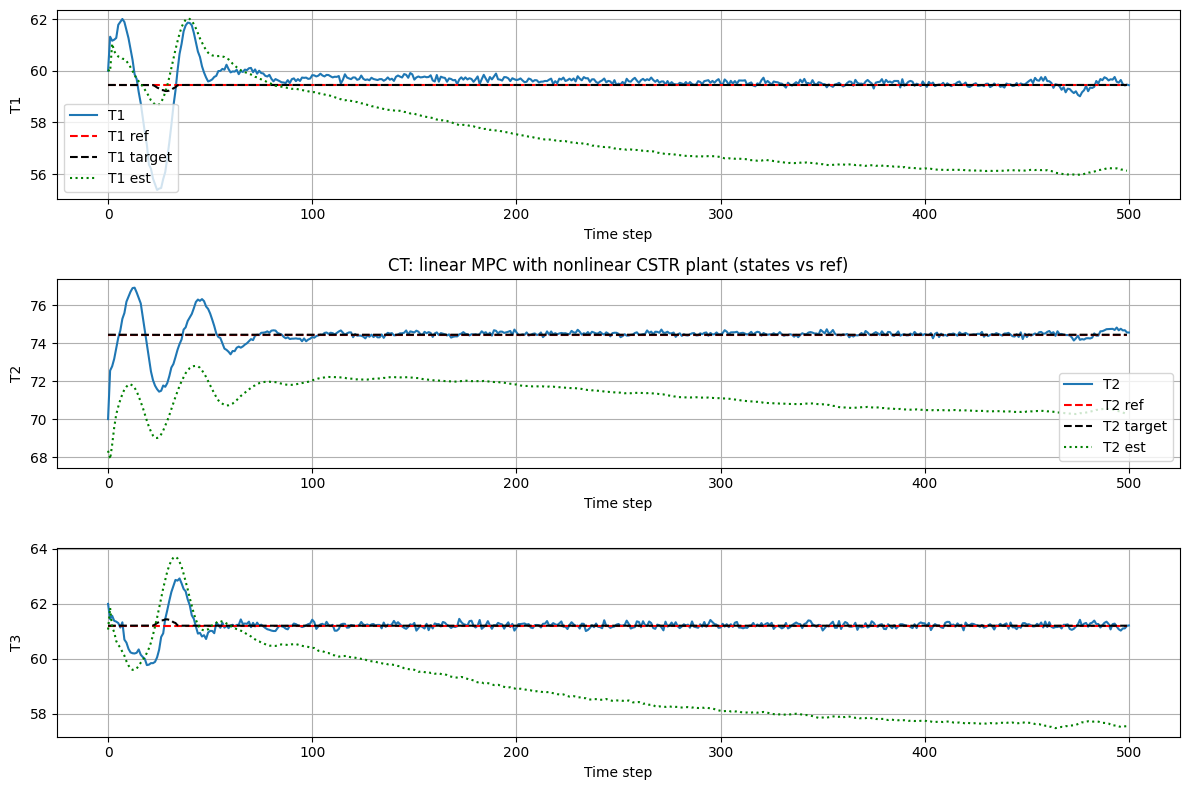

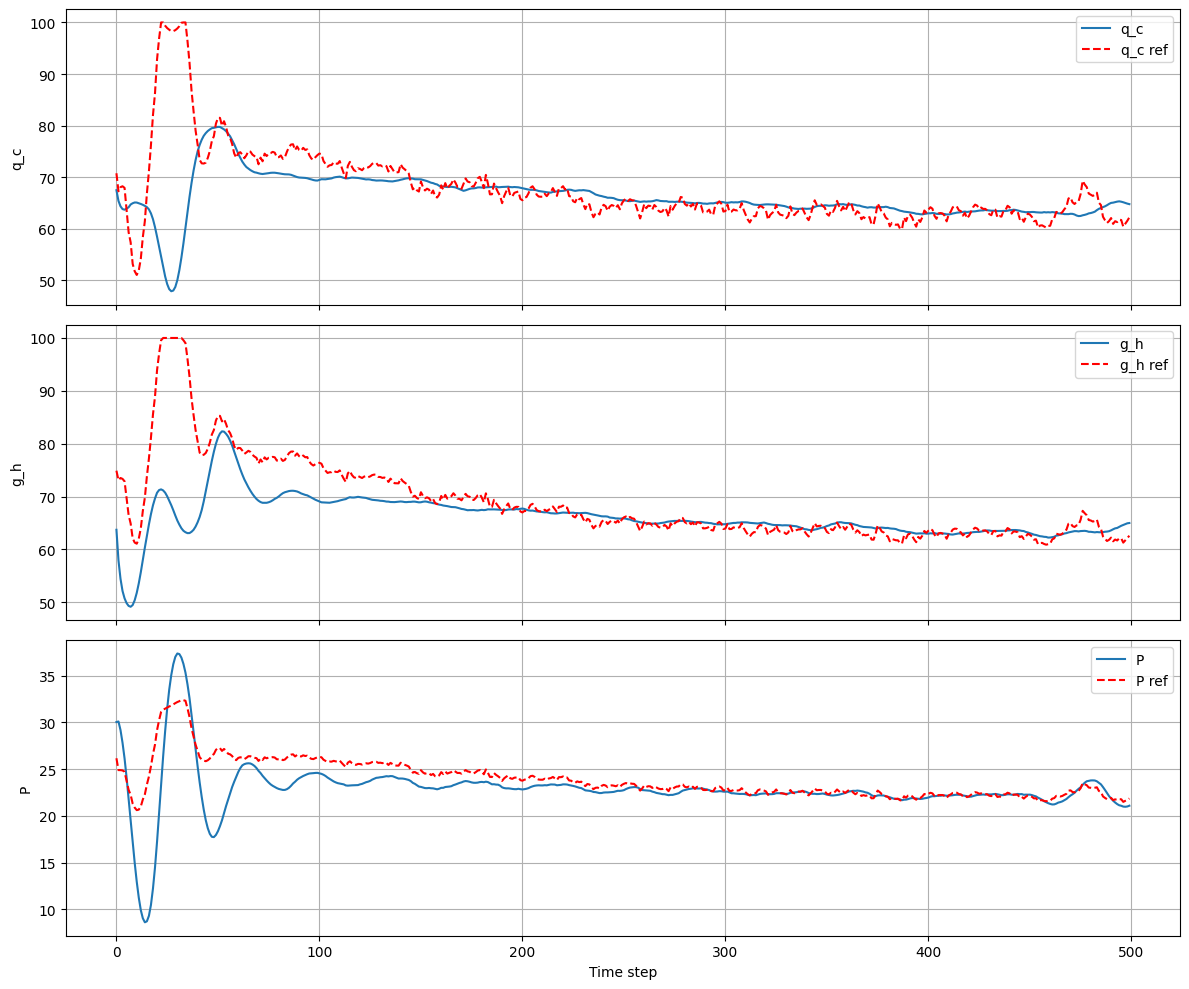

In [26]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    y_ref_k = reference[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
ys_sim_ns = ys_sim
zs_sim_ns = scaler.inverse_transform((C@zs_sim + z_sim[nz:]).T).T
z_sim_ns = scaler.inverse_transform((C@z_sim[:nz]).T).T
us_sim_ns = scalerU.inverse_transform(us_sim.T).T
us_sim_ns = us_sim

names = ['T1','T2','T3']
n_steps = sim_time

fig, axs = plt.subplots(nrows=min(8, ny), ncols=1, figsize=(12, 8))
if min(8, ny) == 1:
    axs = [axs]  # Ensure axs is always iterable
for i in range(min(8, ny)):
    ax = axs[i]
    # Actual output
    ax.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    # Reference trajectory
    if reference_ns is not None:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    # Target/Estimated reference
    ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    # State estimate (plot on top)
    ax.plot(z_sim_ns[i, :n_steps], 'g:', label=f'{names[i]} est' if i < len(names) else f'y{i} est')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0,1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
# fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'g_h', 'P']
for i in range(len(input_names)):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    axs[i].plot(us_sim_ns[i, :], 'r--', label=f"{input_names[i]} ref")
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#781
#767
#545
# 561

In [27]:
sum(u_sim_ns[2,:])

np.float64(11439.122619279817)

In [28]:
sum(sum(z_sim[nz:,:]))

np.float64(516.4099791245629)

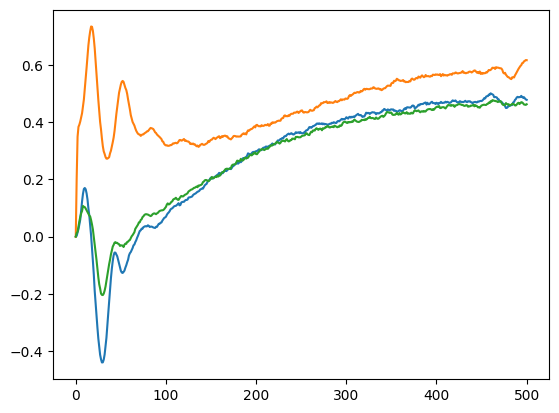

In [29]:
plt.plot(z_sim[nz:,:].T)

In [30]:
C@z_sim[:nz] + z_sim[nz:]

array([[ 0.68216617,  0.67488551,  0.83946964, ...,  0.61123771,
         0.60507169,  0.6032146 ],
       [-0.29868325, -0.15825498,  0.09520898, ...,  0.59512345,
         0.59385774,  0.58710554],
       [ 0.54969996,  0.66425985,  0.57713483, ...,  0.55615411,
         0.55624638,  0.56176932]])

In [31]:
scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T

array([[60.04172279, 59.99054965, 61.1473512 , ..., 59.54319263,
        59.49985393, 59.48680112],
       [68.3323536 , 69.32145364, 71.10671523, ..., 74.62783946,
        74.6189245 , 74.57136571],
       [61.06549221, 61.95393963, 61.27825817, ..., 61.11554613,
        61.11626178, 61.15909387]])

In [32]:
scaler.mean_

array([55.24702672, 70.43611518, 56.80239899])